<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
ELEC PRICE PREDICTION CAPSTONE:</font>  

<font size='4'>Electricity Price DataFrame Creation Notebook  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; (5-minute granularity maintained via fill-forward method)</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Manu Kalia Project Submission<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; DSI-7-SF<br>
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 15-May-2019<br>
</font>

---


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Day-Ahead-Market-DataFrame" data-toc-modified-id="Day-Ahead-Market-DataFrame-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Day-Ahead-Market DataFrame</a></span></li><li><span><a href="#Hour-Ahead-Scheduling-Process-DataFrame" data-toc-modified-id="Hour-Ahead-Scheduling-Process-DataFrame-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hour-Ahead-Scheduling Process DataFrame</a></span></li><li><span><a href="#RTM-DataFrame" data-toc-modified-id="RTM-DataFrame-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RTM DataFrame</a></span></li><li><span><a href="#Join-DAM-+-HASP-+-RTM-LMP's-Into-a-Single-DataFrame" data-toc-modified-id="Join-DAM-+-HASP-+-RTM-LMP's-Into-a-Single-DataFrame-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Join DAM + HASP + RTM LMP's Into a Single DataFrame</a></span></li></ul></div>

---

## Imports

In [1]:
import pandas as pd
import numpy as np

import wget, os
import time
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
sns.set_style('whitegrid')

---

## Day-Ahead-Market DataFrame

In [2]:
dam_orig_cols=['INTERVALSTARTTIME_GMT',
               'OPR_DT',
               'OPR_HR',
               'NODE',
               'MARKET_RUN_ID',
               'LMP_TYPE',
               'MW']

dam_new_cols =['start_datetime',
               'date',
               'hr_index',
               'node',
               'market',
               'lmp_type',
               'dam_price_per_mwh']

dam_rename_dict = {old: new for old, new in zip(dam_orig_cols, dam_new_cols)}

In [3]:
caiso_dam_df = pd.DataFrame(columns=dam_new_cols)

for file in glob.glob('../unzipped_caiso/unzipped_caiso_dam/*.csv'):
    df = pd.read_csv(file, usecols=dam_orig_cols).rename(index=str,
                                                         columns=dam_rename_dict)
    df = df[df.lmp_type == 'LMP']
    caiso_dam_df = caiso_dam_df.append(df, ignore_index=True)

In [4]:
caiso_dam_df.shape

(29149, 7)

In [5]:
caiso_dam_df = caiso_dam_df.sort_values(by='start_datetime').reset_index(drop=True)

caiso_dam_df['start_datetime'] = pd.to_datetime(caiso_dam_df['start_datetime'])

caiso_dam_df.set_index('start_datetime', inplace=True)
caiso_dam_df.sort_index(inplace=True)
caiso_dam_df.head()

,date,hr_index,node,market,lmp_type,dam_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,DAM,LMP,31.69690
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,DAM,LMP,30.38613
2016-01-01 10:00:00+00:00,2016-01-01,3,BAYSHOR2_1_N001,DAM,LMP,30.29141
2016-01-01 11:00:00+00:00,2016-01-01,4,BAYSHOR2_1_N001,DAM,LMP,28.45127
2016-01-01 12:00:00+00:00,2016-01-01,5,BAYSHOR2_1_N001,DAM,LMP,28.66504


In [6]:
caiso_dam_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29149 entries, 2016-01-01 08:00:00+00:00 to 2019-05-01 06:00:00+00:00
Data columns (total 6 columns):
date                 29149 non-null object
hr_index             29149 non-null object
node                 29149 non-null object
market               29149 non-null object
lmp_type             29149 non-null object
dam_price_per_mwh    29149 non-null float64
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


---

## Hour-Ahead-Scheduling Process DataFrame
(hour-ahead, 15-minute realtime market)

In [7]:
hasp_orig_cols=['INTERVALSTARTTIME_GMT',
                'OPR_DT',
                'OPR_HR',
                'NODE',
                'MARKET_RUN_ID',
                'LMP_TYPE',
                'MW']

hasp_new_cols =['start_datetime',
                'date',
                'hr_index',
                'node',
                'market',
                'lmp_type',
                'hasp_price_per_mwh']

hasp_rename_dict = {old: new for old, new in zip(hasp_orig_cols, hasp_new_cols)}

In [8]:
caiso_hasp_df = pd.DataFrame(columns=hasp_new_cols)

for file in glob.glob('../unzipped_caiso/unzipped_caiso_hasp/*.csv'):
    df = pd.read_csv(file, usecols=hasp_orig_cols).rename(index=str,
                                                          columns=hasp_rename_dict)
    df = df[df.lmp_type == 'LMP']
    caiso_hasp_df = caiso_hasp_df.append(df, ignore_index=True)

In [9]:
caiso_hasp_df.shape

(116272, 7)

In [10]:
caiso_hasp_df = caiso_hasp_df.sort_values(by='start_datetime').reset_index(drop=True)

caiso_hasp_df['start_datetime'] = pd.to_datetime(caiso_hasp_df['start_datetime'])

caiso_hasp_df.set_index('start_datetime', inplace=True)
caiso_hasp_df.sort_index(inplace=True)
caiso_hasp_df.head()

,date,hr_index,node,market,lmp_type,hasp_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,25.71969
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,24.54000
2016-01-01 08:30:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,24.53352
2016-01-01 08:45:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,HASP,LMP,24.15808
2016-01-01 09:00:00+00:00,2016-01-01,2,BAYSHOR2_1_N001,HASP,LMP,25.32248


In [11]:
caiso_hasp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116272 entries, 2016-01-01 08:00:00+00:00 to 2019-05-01 06:45:00+00:00
Data columns (total 6 columns):
date                  116272 non-null object
hr_index              116272 non-null object
node                  116272 non-null object
market                116272 non-null object
lmp_type              116272 non-null object
hasp_price_per_mwh    116272 non-null float64
dtypes: float64(1), object(5)
memory usage: 6.2+ MB


---

## RTM DataFrame
(realtime spot prices, 5-minute realtime settlements only)

In [12]:
rtm_orig_cols=['INTERVALSTARTTIME_GMT',
                'OPR_DT',
                'OPR_HR',
                'NODE',
                'MARKET_RUN_ID',
                'LMP_TYPE',
                'VALUE']

rtm_new_cols =['start_datetime',
                'date',
                'hr_index',
                'node',
                'market',
                'lmp_type',
                'rtm_price_per_mwh']

rtm_rename_dict = {old: new for old, new in zip(rtm_orig_cols, rtm_new_cols)}

In [13]:
caiso_rtm_df = pd.DataFrame(columns=rtm_new_cols)

for file in glob.glob('../unzipped_caiso/unzipped_caiso_rtm/*.csv'):
    df = pd.read_csv(file, usecols=rtm_orig_cols).rename(index=str,
                                                          columns=rtm_rename_dict)
    df = df[df.lmp_type == 'LMP']
    caiso_rtm_df = caiso_rtm_df.append(df, ignore_index=True)

In [14]:
caiso_rtm_df.shape

(349728, 7)

In [15]:
caiso_rtm_df = caiso_rtm_df.sort_values(by='start_datetime').reset_index(drop=True)

caiso_rtm_df['start_datetime'] = pd.to_datetime(caiso_rtm_df['start_datetime'])

caiso_rtm_df.set_index('start_datetime', inplace=True)
caiso_rtm_df.sort_index(inplace=True)
caiso_rtm_df.head()

,date,hr_index,node,market,lmp_type,rtm_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.53958
2016-01-01 08:05:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.24638
2016-01-01 08:10:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.54549
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.23638
2016-01-01 08:20:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,RTM,LMP,25.23638


In [16]:
caiso_rtm_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 349728 entries, 2016-01-01 08:00:00+00:00 to 2019-05-01 06:55:00+00:00
Data columns (total 6 columns):
date                 349728 non-null object
hr_index             349728 non-null object
node                 349728 non-null object
market               349728 non-null object
lmp_type             349728 non-null object
rtm_price_per_mwh    349728 non-null float64
dtypes: float64(1), object(5)
memory usage: 18.7+ MB


---

## Join DAM + HASP + RTM LMP's Into a Single DataFrame

In [17]:
elec_prices_5min = caiso_rtm_df.drop(columns=['market', 'lmp_type'])
elec_prices_5min.shape

(349728, 4)

In [18]:
elec_prices_5min.head()

,date,hr_index,node,rtm_price_per_mwh
start_datetime,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.53958
2016-01-01 08:05:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.24638
2016-01-01 08:10:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.54549
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638
2016-01-01 08:20:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638


In [19]:
elec_prices_5min = elec_prices_5min.merge(caiso_hasp_df[['hasp_price_per_mwh']],
                              how='outer',
                              left_index = True,
                              right_index = True)
elec_prices_5min.shape

(349748, 5)

In [20]:
elec_prices_5min.head(15)

,date,hr_index,node,rtm_price_per_mwh,hasp_price_per_mwh
start_datetime,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.53958,25.71969
2016-01-01 08:05:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.24638,NaN
2016-01-01 08:10:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.54549,NaN
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638,24.54000
2016-01-01 08:20:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638,NaN
2016-01-01 08:25:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.35463,NaN
2016-01-01 08:30:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.34947,24.53352
2016-01-01 08:35:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.34947,NaN
2016-01-01 08:40:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.13279,NaN


In [21]:
elec_prices_5min = elec_prices_5min.merge(caiso_dam_df[['dam_price_per_mwh']],
                              how='outer',
                              left_index = True,
                              right_index = True)
elec_prices_5min.shape

(349748, 6)

In [22]:
elec_prices_5min.head(15)

,date,hr_index,node,rtm_price_per_mwh,hasp_price_per_mwh,dam_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.53958,25.71969,31.69690
2016-01-01 08:05:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.24638,NaN,NaN
2016-01-01 08:10:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.54549,NaN,NaN
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638,24.54000,NaN
2016-01-01 08:20:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638,NaN,NaN
2016-01-01 08:25:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.35463,NaN,NaN
2016-01-01 08:30:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.34947,24.53352,NaN
2016-01-01 08:35:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.34947,NaN,NaN
2016-01-01 08:40:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.13279,NaN,NaN


In [23]:
elec_prices_5min.isna().sum().sum()

554155

In [24]:
elec_prices_5min.fillna(method='ffill', inplace=True)

In [25]:
elec_prices_5min.isna().sum().sum()

0

In [26]:
elec_prices_5min.shape

(349748, 6)

In [27]:
elec_prices_5min.head(20)

,date,hr_index,node,rtm_price_per_mwh,hasp_price_per_mwh,dam_price_per_mwh
start_datetime,,,,,,
2016-01-01 08:00:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.53958,25.71969,31.69690
2016-01-01 08:05:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.24638,25.71969,31.69690
2016-01-01 08:10:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.54549,25.71969,31.69690
2016-01-01 08:15:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638,24.54000,31.69690
2016-01-01 08:20:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.23638,24.54000,31.69690
2016-01-01 08:25:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.35463,24.54000,31.69690
2016-01-01 08:30:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.34947,24.53352,31.69690
2016-01-01 08:35:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.34947,24.53352,31.69690
2016-01-01 08:40:00+00:00,2016-01-01,1,BAYSHOR2_1_N001,25.13279,24.53352,31.69690


In [28]:
elec_prices_5min.tail(20)

,date,hr_index,node,rtm_price_per_mwh,hasp_price_per_mwh,dam_price_per_mwh
start_datetime,,,,,,
2019-05-01 05:20:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,1055.10000,43.35965,35.00692
2019-05-01 05:25:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,1055.10000,43.35965,35.00692
2019-05-01 05:30:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,1052.30000,45.79919,35.00692
2019-05-01 05:35:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,1052.30000,45.79919,35.00692
2019-05-01 05:40:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,1052.30000,45.79919,35.00692
2019-05-01 05:45:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,59.83245,38.93824,35.00692
2019-05-01 05:50:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,189.74080,38.93824,35.00692
2019-05-01 05:55:00+00:00,2019-04-30,23,BAYSHOR2_1_N001,54.51200,38.93824,35.00692
2019-05-01 06:00:00+00:00,2019-04-30,24,BAYSHOR2_1_N001,33.42621,33.17909,25.13543


In [29]:
# elec_prices_5min.to_csv('../data/elec_prices_5min.csv')

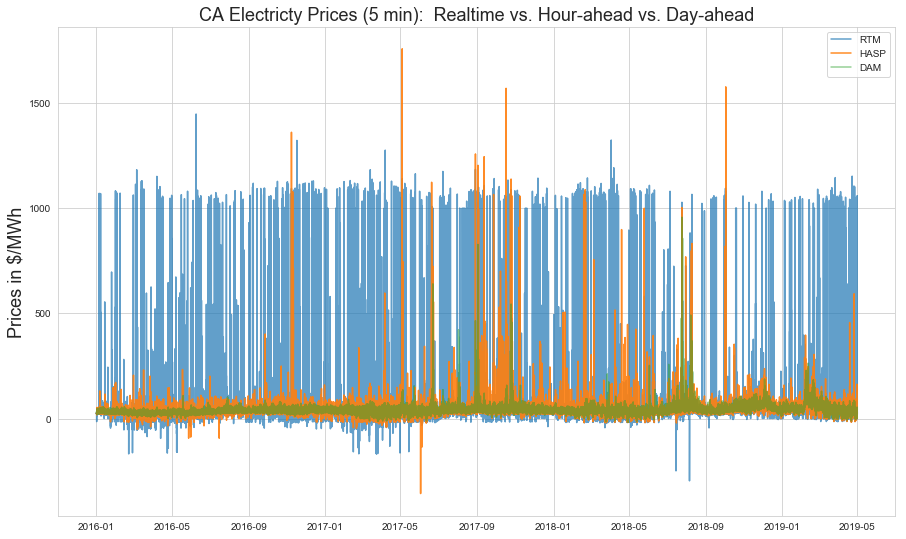

''

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize=(15,9))
plt.title('CA Electricty Prices (5 min):  Realtime vs. Hour-ahead vs. Day-ahead', fontsize=18)

plt.plot(elec_prices_5min.index,
         elec_prices_5min.rtm_price_per_mwh,
         label = 'RTM', alpha=0.7)

plt.plot(elec_prices_5min.index,
         elec_prices_5min.hasp_price_per_mwh,
         label= 'HASP', alpha=0.9)

plt.plot(elec_prices_5min.index,
         elec_prices_5min.dam_price_per_mwh,
         label = 'DAM', alpha=0.5)

plt.ylabel('Prices in $/MWh', fontsize=18)
plt.legend()
plt.show()
plt.savefig('../images/elec_prices_5min.jpg', bbox_inches='tight')
;